In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy
from utils import Predicate,Clause,KnowledgeBase, Propositional
from utils import load_knowledge_base,load_propositional

In [20]:
emb_dim=10

In [4]:
def show_results(model, knowledge_base):
    wrong=0
    for clause in knowledge_base.clauses:
        output=model.forward(clause=clause)
        if output[0].data.numpy()[0]<0.01:
            continue
        print(clause.show())
        print(output[0].data.numpy()[0], output[1].data.numpy()[0])
        wrong+=1
    print(wrong)

In [8]:
class GConstants(nn.Module):
    def __init__(self, constants,emb_dim):
        super(GConstants, self).__init__()
        self.symbol2id=dict()
        self.id2symbol=dict()
        for i,s in enumerate(constants):
            self.symbol2id[s]=i
            self.id2symbol[i]=s
        self.embeddings = nn.Embedding(len(self.symbol2id), emb_dim)
    def forward(self,constants):
        constant_id=[]
        for c in constants:
            constant_id.append(self.symbol2id[c])
        embs=self.embeddings(Variable(torch.LongTensor(constant_id)))
        embs=torch.cat(embs).view(1,-1)
        return embs

In [17]:
class LTN(nn.Module):
    def __init__(self, emb_dim, constants, predicates):
        super(LTN, self).__init__()
        self.emb_dim=emb_dim
        self.Constants=GConstants(constants, emb_dim)
        self.Predicates=dict()
        for name,n in predicates:
            self.Predicates[name]=GPredicate(name,n,emb_dim)
    def forward(self, clause):
        Phi=None
        v=Variable(torch.FloatTensor([clause.v]))
        w=Variable(torch.FloatTensor([clause.w]))
        for predicate in clause.predicates:
            negation=predicate.negation
            name=predicate.name
            constants=predicate.variables
            embs=self.Constants.forward(constants)
            output=self.Predicates[name].forward(embs,negation)
            if Phi is None or Phi.data.numpy()[0]<output.data.numpy()[0]:
                Phi=output
        if (Phi>w).data.all():
            loss=Phi-w
        elif (Phi<v).data.all():
            loss=v-Phi
        else:
            loss=Variable(torch.FloatTensor([0]),requires_grad=True)
        return loss,Phi
    def parameters(self):
        results=list(self.Constants.parameters())
        for name in self.Predicates:
            results+=list(self.Predicates[name].parameters())
        return results

In [18]:
kb1=load_knowledge_base('./facts1.txt')
kb2=load_knowledge_base('./facts2.txt')
propositionals=load_propositional('./knowledge.txt')
gkbs1=[]
for p in propositionals:
    gkbs1.append(p.generate_knowledge_base('abcdefgh'))
gkb1=gkbs1[0]
for tkb in gkbs1[1:]:
    gkb1=gkb1.union(tkb)
gkbs2=[]
for p in propositionals:
    gkbs2.append(p.generate_knowledge_base('ijklmn'))
gkb2=gkbs2[0]
for tkb in gkbs2[1:]:
    gkb2=gkb2.union(tkb)

  0%|          | 0/2000 [00:00<?, ?it/s]

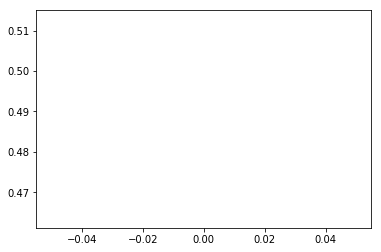

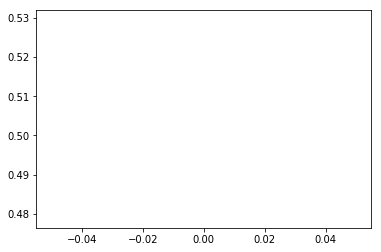

  0%|          | 1/2000 [00:00<31:34,  1.06it/s]

S(a)
[ 0.43360639] [ 0.56639361]
S(e)
[ 0.27917832] [ 0.72082168]
S(f)
[ 0.33024299] [ 0.66975701]
S(g)
[ 0.35235035] [ 0.64764965]
¬S(b)
[ 0.25084233] [ 0.74915767]
¬S(c)
[ 0.21292365] [ 0.78707635]
¬S(d)
[ 0.31742001] [ 0.68257999]
¬S(h)
[ 0.40868449] [ 0.59131551]
F(a, b)
[ 0.22070754] [ 0.77929246]
F(a, e)
[ 0.57059687] [ 0.42940313]
F(a, f)
[ 0.82219583] [ 0.17780417]
F(a, g)
[ 0.64854002] [ 0.35146001]
F(b, c)
[ 0.39501935] [ 0.60498065]
F(c, d)
[ 0.33415866] [ 0.66584134]
F(e, f)
[ 0.8370586] [ 0.1629414]
F(g, h)
[ 0.71584946] [ 0.28415054]
¬F(a, c)
[ 0.66680169] [ 0.33319831]
¬F(a, d)
[ 0.13460755] [ 0.86539245]
¬F(a, h)
[ 0.29907346] [ 0.70092654]
¬F(b, d)
[ 0.25862163] [ 0.74137837]
¬F(b, e)
[ 0.14571118] [ 0.85428882]
¬F(b, f)
[ 0.13395321] [ 0.86604679]
¬F(b, g)
[ 0.16626906] [ 0.83373094]
¬F(b, h)
[ 0.11595905] [ 0.88404095]
¬F(c, e)
[ 0.12704384] [ 0.87295616]
¬F(c, f)
[ 0.12604856] [ 0.87395144]
¬F(c, g)
[ 0.23126352] [ 0.76873648]
¬F(c, h)
[ 0.12130314] [ 0.87869686]
¬F

  5%|▌         | 100/2000 [00:27<08:34,  3.69it/s]

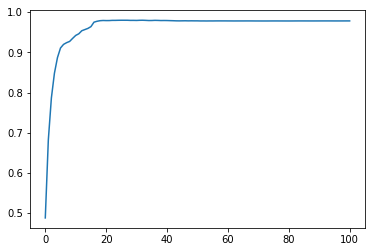

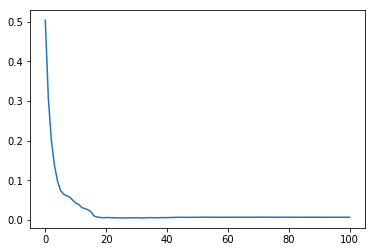

  5%|▌         | 101/2000 [00:27<08:40,  3.65it/s]

S(a)
[ 0.01231712] [ 0.98768288]
S(f)
[ 0.01427805] [ 0.98572195]
C(a)
[ 0.01132846] [ 0.98867154]
C(e)
[ 0.02248323] [ 0.97751677]
¬C(b)
[ 0.01698709] [ 0.98301291]
¬C(c)
[ 0.01190966] [ 0.98809034]
¬C(d)
[ 0.01343602] [ 0.98656398]
¬C(f)
[ 0.01684999] [ 0.98315001]
¬C(g)
[ 0.01166141] [ 0.98833859]
¬C(h)
[ 0.01131207] [ 0.98868793]
S(n)
[ 0.01224267] [ 0.98775733]
¬S(j)
[ 0.01194686] [ 0.98805314]
¬S(k)
[ 0.01452559] [ 0.98547441]
¬S(l)
[ 0.01278108] [ 0.98721892]
¬S(m)
[ 0.0132125] [ 0.9867875]
15


 10%|█         | 200/2000 [00:57<08:35,  3.49it/s]

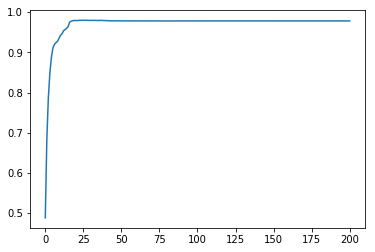

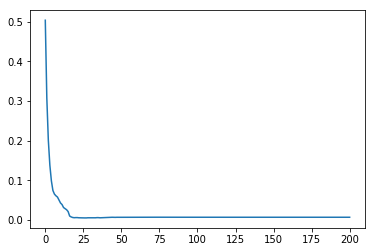

 10%|█         | 201/2000 [00:57<08:37,  3.47it/s]

S(a)
[ 0.01232225] [ 0.98767775]
S(f)
[ 0.01469463] [ 0.98530537]
C(a)
[ 0.0112167] [ 0.9887833]
C(e)
[ 0.02244496] [ 0.97755504]
¬C(b)
[ 0.01714808] [ 0.98285192]
¬C(c)
[ 0.01171583] [ 0.98828417]
¬C(d)
[ 0.01318556] [ 0.98681444]
¬C(f)
[ 0.01668453] [ 0.98331547]
¬C(g)
[ 0.01169348] [ 0.98830652]
¬C(h)
[ 0.01109451] [ 0.98890549]
S(n)
[ 0.0124526] [ 0.9875474]
¬S(j)
[ 0.01198345] [ 0.98801655]
¬S(k)
[ 0.01485431] [ 0.98514569]
¬S(l)
[ 0.01291025] [ 0.98708975]
¬S(m)
[ 0.01329327] [ 0.98670673]
15


 15%|█▌        | 300/2000 [01:41<09:36,  2.95it/s]

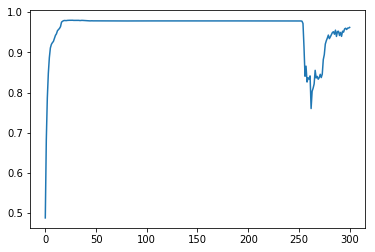

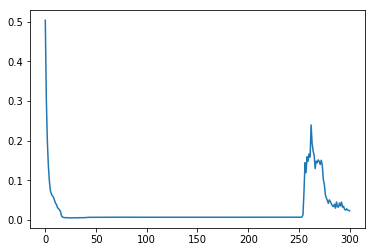

 15%|█▌        | 301/2000 [01:42<09:39,  2.93it/s]

S(a)
[ 0.01196265] [ 0.98803735]
S(e)
[ 0.01121122] [ 0.98878878]
S(f)
[ 0.01094216] [ 0.98905784]
¬S(b)
[ 0.02100641] [ 0.97899359]
¬S(c)
[ 0.02668822] [ 0.97331178]
¬S(h)
[ 0.01473582] [ 0.98526418]
F(b, c)
[ 0.99993211] [  6.78912111e-05]
F(c, d)
[ 0.01015848] [ 0.98984152]
F(e, f)
[ 0.02045006] [ 0.97954994]
¬F(e, g)
[ 0.01803136] [ 0.98196864]
C(a)
[ 0.01063365] [ 0.98936635]
C(e)
[ 0.01783127] [ 0.98216873]
S(i)
[ 0.01095754] [ 0.98904246]
S(n)
[ 0.01349223] [ 0.98650777]
¬S(j)
[ 0.0321216] [ 0.9678784]
¬S(k)
[ 0.02556026] [ 0.97443974]
¬S(l)
[ 0.03148884] [ 0.96851116]
¬S(m)
[ 0.03002757] [ 0.96997243]
F(m, n)
[ 0.02554554] [ 0.97445446]
¬F(i, n)
[ 0.01175994] [ 0.98824006]
20


 20%|██        | 400/2000 [02:22<09:28,  2.81it/s]

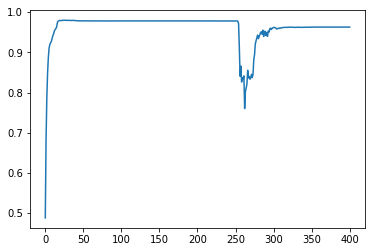

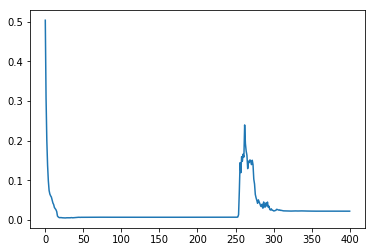

S(a)
[ 0.01141948] [ 0.98858052]
S(f)
[ 0.01358271] [ 0.98641729]
¬S(b)
[ 0.01102483] [ 0.98897517]
F(a, g)
[ 0.01050359] [ 0.98949641]
F(b, c)
[ 0.99698925] [ 0.00301075]
¬F(e, g)
[ 0.01098281] [ 0.98901719]
C(a)
[ 0.01239294] [ 0.98760706]
C(e)
[ 0.01983935] [ 0.98016065]
¬C(b)
[ 0.01563042] [ 0.98436958]
¬C(c)
[ 0.01398247] [ 0.98601753]
¬C(d)
[ 0.01234418] [ 0.98765582]
¬C(f)
[ 0.01579106] [ 0.98420894]
¬C(g)
[ 0.0127449] [ 0.9872551]
¬C(h)
[ 0.01306474] [ 0.98693526]
S(i)
[ 0.01100373] [ 0.98899627]
S(n)
[ 0.01324677] [ 0.98675323]


 20%|██        | 401/2000 [02:23<09:30,  2.80it/s]

¬S(j)
[ 0.01066613] [ 0.98933387]
¬S(k)
[ 0.01456487] [ 0.98543513]
¬S(l)
[ 0.01068693] [ 0.98931307]
¬S(m)
[ 0.01392269] [ 0.98607731]
20


 25%|██▌       | 500/2000 [02:55<08:46,  2.85it/s]

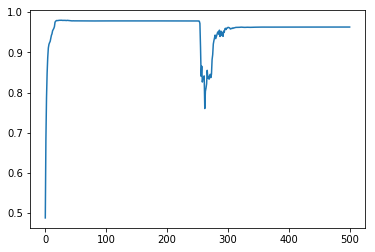

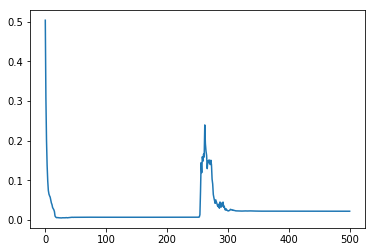

 25%|██▌       | 501/2000 [02:56<08:47,  2.84it/s]

S(a)
[ 0.01329464] [ 0.98670536]
S(f)
[ 0.01410431] [ 0.98589569]
¬S(b)
[ 0.01123786] [ 0.98876214]
F(b, c)
[ 0.99808323] [ 0.00191675]
¬F(e, g)
[ 0.01005459] [ 0.98994541]
C(a)
[ 0.0115335] [ 0.9884665]
C(e)
[ 0.02102864] [ 0.97897136]
¬C(b)
[ 0.01505196] [ 0.98494804]
¬C(c)
[ 0.01364493] [ 0.98635507]
¬C(d)
[ 0.01209998] [ 0.98790002]
¬C(f)
[ 0.01520991] [ 0.98479009]
¬C(g)
[ 0.01257551] [ 0.98742449]
¬C(h)
[ 0.01386374] [ 0.98613626]
S(n)
[ 0.01221174] [ 0.98778826]
¬S(k)
[ 0.01435685] [ 0.98564315]
¬S(l)
[ 0.01031315] [ 0.98968685]
¬S(m)
[ 0.01471794] [ 0.98528206]
17


 30%|███       | 600/2000 [03:35<08:22,  2.79it/s]

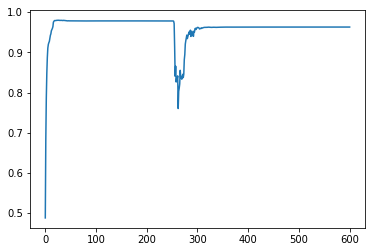

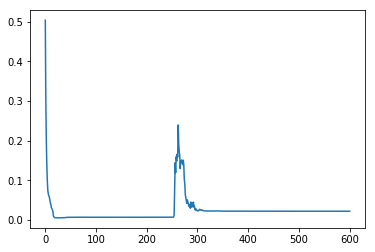

 30%|███       | 601/2000 [03:36<08:23,  2.78it/s]

S(a)
[ 0.01255709] [ 0.98744291]
S(f)
[ 0.01483035] [ 0.98516965]
¬S(b)
[ 0.01075488] [ 0.98924512]
F(b, c)
[ 0.99774039] [ 0.00225963]
¬F(e, g)
[ 0.01093256] [ 0.98906744]
C(a)
[ 0.01101083] [ 0.98898917]
C(e)
[ 0.0223406] [ 0.9776594]
¬C(b)
[ 0.01630682] [ 0.98369318]
¬C(c)
[ 0.01458782] [ 0.98541218]
¬C(d)
[ 0.01195008] [ 0.98804992]
¬C(f)
[ 0.0153017] [ 0.9846983]
¬C(g)
[ 0.01138848] [ 0.98861152]
¬C(h)
[ 0.0135206] [ 0.9864794]
S(n)
[ 0.01336473] [ 0.98663527]
¬S(j)
[ 0.01087719] [ 0.98912281]
¬S(k)
[ 0.0154838] [ 0.9845162]
¬S(l)
[ 0.01019317] [ 0.98980683]
¬S(m)
[ 0.01267534] [ 0.98732466]
18


 35%|███▌      | 700/2000 [04:14<07:51,  2.75it/s]

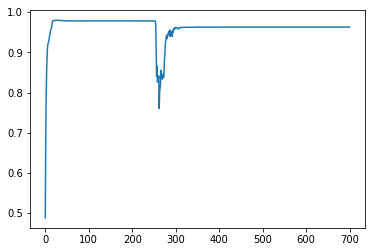

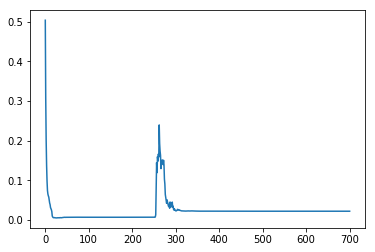

 35%|███▌      | 701/2000 [04:14<07:51,  2.75it/s]

S(a)
[ 0.0117541] [ 0.9882459]
S(f)
[ 0.01441365] [ 0.98558635]
¬S(b)
[ 0.01076263] [ 0.98923737]
F(b, c)
[ 0.99781662] [ 0.00218338]
¬F(e, g)
[ 0.01073664] [ 0.98926336]
C(a)
[ 0.01150507] [ 0.98849493]
C(e)
[ 0.02188259] [ 0.97811741]
¬C(b)
[ 0.01641744] [ 0.98358256]
¬C(c)
[ 0.0145151] [ 0.9854849]
¬C(d)
[ 0.01192528] [ 0.98807472]
¬C(f)
[ 0.01556695] [ 0.98443305]
¬C(g)
[ 0.01117003] [ 0.98882997]
¬C(h)
[ 0.01355779] [ 0.98644221]
S(n)
[ 0.01320165] [ 0.98679835]
¬S(j)
[ 0.01095092] [ 0.98904908]
¬S(k)
[ 0.01556516] [ 0.98443484]
¬S(m)
[ 0.01250911] [ 0.98749089]
17


 40%|████      | 800/2000 [04:39<06:59,  2.86it/s]

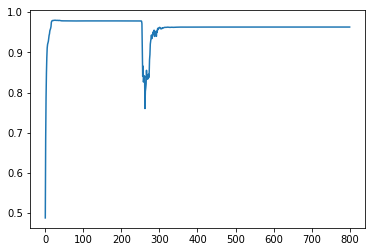

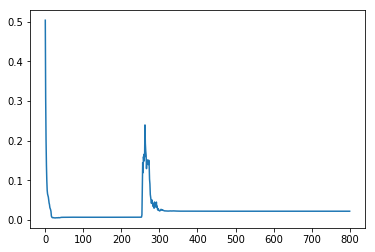

 40%|████      | 801/2000 [04:40<06:59,  2.86it/s]

S(a)
[ 0.01154494] [ 0.98845506]
S(f)
[ 0.01425338] [ 0.98574662]
¬S(b)
[ 0.01076144] [ 0.98923856]
F(b, c)
[ 0.99785244] [ 0.00214755]
¬F(e, g)
[ 0.01068521] [ 0.98931479]
C(a)
[ 0.01158893] [ 0.98841107]
C(e)
[ 0.02177227] [ 0.97822773]
¬C(b)
[ 0.016424] [ 0.983576]
¬C(c)
[ 0.01452959] [ 0.98547041]
¬C(d)
[ 0.01191127] [ 0.98808873]
¬C(f)
[ 0.01564091] [ 0.98435909]
¬C(g)
[ 0.0111233] [ 0.9888767]
¬C(h)
[ 0.01358736] [ 0.98641264]
S(n)
[ 0.01318401] [ 0.98681599]
¬S(j)
[ 0.01099443] [ 0.98900557]
¬S(k)
[ 0.01538581] [ 0.98461419]
¬S(m)
[ 0.01247138] [ 0.98752862]
17


 45%|████▌     | 900/2000 [05:06<06:14,  2.94it/s]

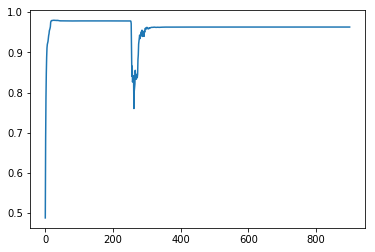

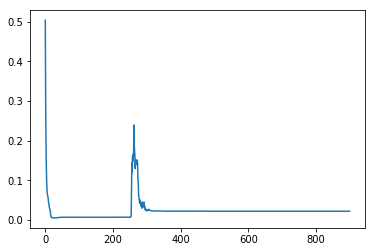

 45%|████▌     | 901/2000 [05:06<06:14,  2.94it/s]

S(a)
[ 0.01151651] [ 0.98848349]
S(f)
[ 0.01422662] [ 0.98577338]
¬S(b)
[ 0.01076621] [ 0.98923379]
F(b, c)
[ 0.99786019] [ 0.00213982]
¬F(e, g)
[ 0.01068479] [ 0.98931521]
C(a)
[ 0.01159084] [ 0.98840916]
C(e)
[ 0.0217644] [ 0.9782356]
¬C(b)
[ 0.01642138] [ 0.98357862]
¬C(c)
[ 0.01452845] [ 0.98547155]
¬C(d)
[ 0.01190323] [ 0.98809677]
¬C(f)
[ 0.01565444] [ 0.98434556]
¬C(g)
[ 0.01111484] [ 0.98888516]
¬C(h)
[ 0.01360226] [ 0.98639774]
S(n)
[ 0.01318598] [ 0.98681402]
¬S(j)
[ 0.01099926] [ 0.98900074]
¬S(k)
[ 0.01535255] [ 0.98464745]
¬S(m)
[ 0.01246285] [ 0.98753715]
17


 50%|█████     | 1000/2000 [05:32<05:32,  3.01it/s]

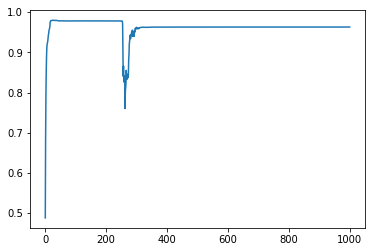

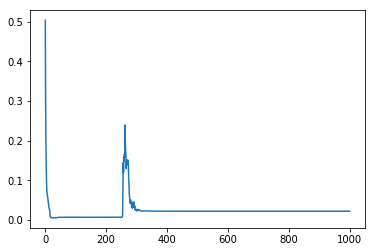

 50%|█████     | 1001/2000 [05:32<05:32,  3.01it/s]

S(a)
[ 0.0115115] [ 0.9884885]
S(f)
[ 0.01422095] [ 0.98577905]
¬S(b)
[ 0.01076752] [ 0.98923248]
F(b, c)
[ 0.9978618] [ 0.00213822]
¬F(e, g)
[ 0.01068538] [ 0.98931462]
C(a)
[ 0.01159048] [ 0.98840952]
C(e)
[ 0.02176327] [ 0.97823673]
¬C(b)
[ 0.01642066] [ 0.98357934]
¬C(c)
[ 0.01452792] [ 0.98547208]
¬C(d)
[ 0.01190144] [ 0.98809856]
¬C(f)
[ 0.01565707] [ 0.98434293]
¬C(g)
[ 0.01111317] [ 0.98888683]
¬C(h)
[ 0.01360583] [ 0.98639417]
S(n)
[ 0.01318669] [ 0.98681331]
¬S(j)
[ 0.01099986] [ 0.98900014]
¬S(k)
[ 0.01534581] [ 0.98465419]
¬S(m)
[ 0.01246107] [ 0.98753893]
17


 55%|█████▌    | 1100/2000 [05:59<04:54,  3.06it/s]

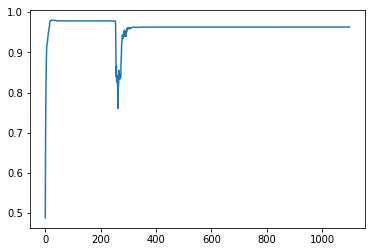

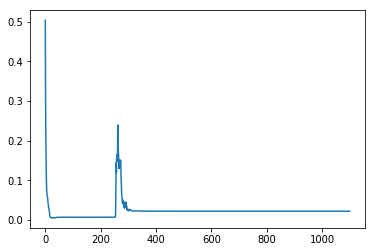

 55%|█████▌    | 1101/2000 [06:00<04:54,  3.05it/s]

S(a)
[ 0.01151031] [ 0.98848969]
S(f)
[ 0.01421934] [ 0.98578066]
¬S(b)
[ 0.01076788] [ 0.98923212]
F(b, c)
[ 0.99786222] [ 0.0021378]
¬F(e, g)
[ 0.01068562] [ 0.98931438]
C(a)
[ 0.01159036] [ 0.98840964]
C(e)
[ 0.02176291] [ 0.97823709]
¬C(b)
[ 0.01642042] [ 0.98357958]
¬C(c)
[ 0.01452768] [ 0.98547232]
¬C(d)
[ 0.01190102] [ 0.98809898]
¬C(f)
[ 0.01565772] [ 0.98434228]
¬C(g)
[ 0.01111275] [ 0.98888725]
¬C(h)
[ 0.01360685] [ 0.98639315]
S(n)
[ 0.01318693] [ 0.98681307]
¬S(j)
[ 0.01099998] [ 0.98900002]
¬S(k)
[ 0.01534402] [ 0.98465598]
¬S(m)
[ 0.01246053] [ 0.98753947]
17


 60%|██████    | 1200/2000 [06:24<04:16,  3.12it/s]

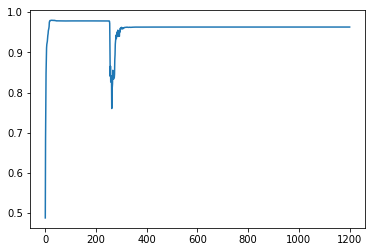

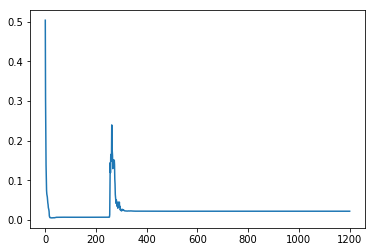

 60%|██████    | 1201/2000 [06:25<04:16,  3.12it/s]

S(a)
[ 0.01151007] [ 0.98848993]
S(f)
[ 0.01421887] [ 0.98578113]
¬S(b)
[ 0.010768] [ 0.989232]
F(b, c)
[ 0.99786234] [ 0.00213768]
¬F(e, g)
[ 0.01068574] [ 0.98931426]
C(a)
[ 0.01159036] [ 0.98840964]
C(e)
[ 0.02176279] [ 0.97823721]
¬C(b)
[ 0.0164203] [ 0.9835797]
¬C(c)
[ 0.01452762] [ 0.98547238]
¬C(d)
[ 0.01190084] [ 0.98809916]
¬C(f)
[ 0.0156579] [ 0.9843421]
¬C(g)
[ 0.01111263] [ 0.98888737]
¬C(h)
[ 0.01360708] [ 0.98639292]
S(n)
[ 0.01318693] [ 0.98681307]
¬S(j)
[ 0.01100004] [ 0.98899996]
¬S(k)
[ 0.01534355] [ 0.98465645]
¬S(m)
[ 0.01246041] [ 0.98753959]
17


 65%|██████▌   | 1300/2000 [06:55<03:43,  3.13it/s]

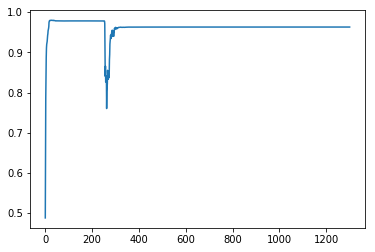

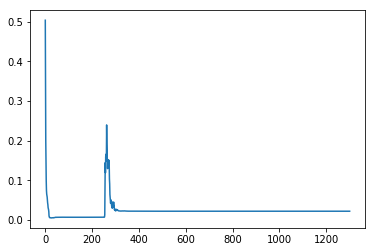

 65%|██████▌   | 1301/2000 [06:55<03:43,  3.13it/s]

S(a)
[ 0.0115099] [ 0.9884901]
S(f)
[ 0.01421887] [ 0.98578113]
¬S(b)
[ 0.010768] [ 0.989232]
F(b, c)
[ 0.99786234] [ 0.00213765]
¬F(e, g)
[ 0.01068562] [ 0.98931438]
C(a)
[ 0.01159024] [ 0.98840976]
C(e)
[ 0.02176279] [ 0.97823721]
¬C(b)
[ 0.01642025] [ 0.98357975]
¬C(c)
[ 0.01452762] [ 0.98547238]
¬C(d)
[ 0.01190084] [ 0.98809916]
¬C(f)
[ 0.01565796] [ 0.98434204]
¬C(g)
[ 0.01111263] [ 0.98888737]
¬C(h)
[ 0.0136072] [ 0.9863928]
S(n)
[ 0.01318693] [ 0.98681307]
¬S(j)
[ 0.0110001] [ 0.9889999]
¬S(k)
[ 0.01534337] [ 0.98465663]
¬S(m)
[ 0.01246041] [ 0.98753959]
17


 70%|███████   | 1400/2000 [07:29<03:12,  3.12it/s]

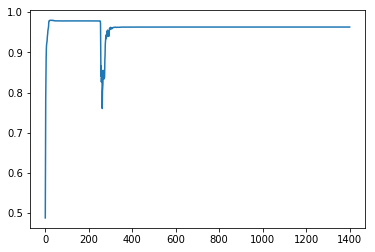

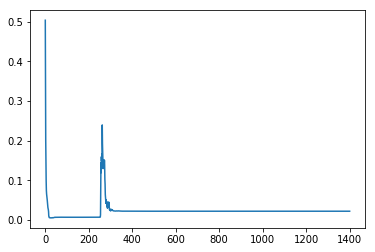

 70%|███████   | 1401/2000 [07:30<03:12,  3.11it/s]

S(a)
[ 0.0115099] [ 0.9884901]
S(f)
[ 0.01421887] [ 0.98578113]
¬S(b)
[ 0.010768] [ 0.989232]
F(b, c)
[ 0.99786234] [ 0.00213763]
¬F(e, g)
[ 0.01068568] [ 0.98931432]
C(a)
[ 0.01159024] [ 0.98840976]
C(e)
[ 0.02176291] [ 0.97823709]
¬C(b)
[ 0.0164203] [ 0.9835797]
¬C(c)
[ 0.01452762] [ 0.98547238]
¬C(d)
[ 0.01190084] [ 0.98809916]
¬C(f)
[ 0.01565796] [ 0.98434204]
¬C(g)
[ 0.01111263] [ 0.98888737]
¬C(h)
[ 0.0136072] [ 0.9863928]
S(n)
[ 0.01318693] [ 0.98681307]
¬S(j)
[ 0.0110001] [ 0.9889999]
¬S(k)
[ 0.01534337] [ 0.98465663]
¬S(m)
[ 0.01246041] [ 0.98753959]
17


 75%|███████▌  | 1500/2000 [07:56<02:38,  3.15it/s]

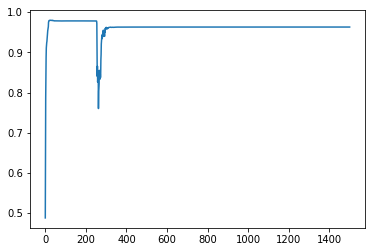

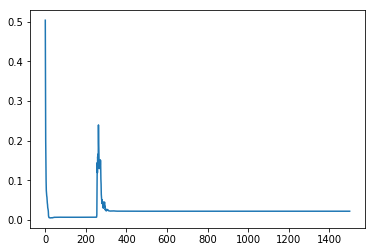

 75%|███████▌  | 1501/2000 [07:57<02:38,  3.15it/s]

S(a)
[ 0.0115099] [ 0.9884901]
S(f)
[ 0.01421875] [ 0.98578125]
¬S(b)
[ 0.010768] [ 0.989232]
F(b, c)
[ 0.99786234] [ 0.00213764]
¬F(e, g)
[ 0.01068592] [ 0.98931408]
C(a)
[ 0.01159024] [ 0.98840976]
C(e)
[ 0.02176279] [ 0.97823721]
¬C(b)
[ 0.01642025] [ 0.98357975]
¬C(c)
[ 0.01452762] [ 0.98547238]
¬C(d)
[ 0.01190084] [ 0.98809916]
¬C(f)
[ 0.01565796] [ 0.98434204]
¬C(g)
[ 0.01111263] [ 0.98888737]
¬C(h)
[ 0.0136072] [ 0.9863928]
S(n)
[ 0.01318693] [ 0.98681307]
¬S(j)
[ 0.0110001] [ 0.9889999]
¬S(k)
[ 0.01534337] [ 0.98465663]
¬S(m)
[ 0.01246035] [ 0.98753965]
17


 80%|████████  | 1600/2000 [08:24<02:06,  3.17it/s]

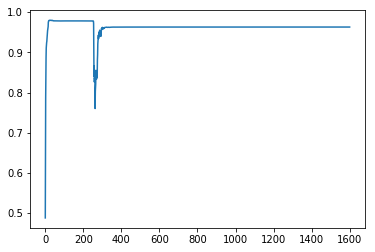

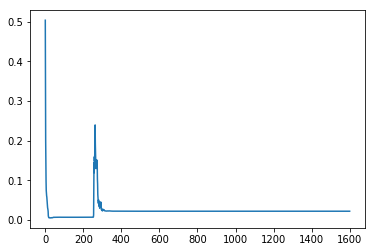

 80%|████████  | 1601/2000 [08:25<02:06,  3.17it/s]

S(a)
[ 0.0115099] [ 0.9884901]
S(f)
[ 0.01421875] [ 0.98578125]
¬S(b)
[ 0.010768] [ 0.989232]
F(b, c)
[ 0.99786234] [ 0.00213764]
¬F(e, g)
[ 0.01068622] [ 0.98931378]
C(a)
[ 0.01159024] [ 0.98840976]
C(e)
[ 0.02176279] [ 0.97823721]
¬C(b)
[ 0.01642025] [ 0.98357975]
¬C(c)
[ 0.01452762] [ 0.98547238]
¬C(d)
[ 0.01190084] [ 0.98809916]
¬C(f)
[ 0.01565796] [ 0.98434204]
¬C(g)
[ 0.01111263] [ 0.98888737]
¬C(h)
[ 0.0136072] [ 0.9863928]
S(n)
[ 0.01318693] [ 0.98681307]
¬S(j)
[ 0.01100004] [ 0.98899996]
¬S(k)
[ 0.01534337] [ 0.98465663]
¬S(m)
[ 0.01246041] [ 0.98753959]
17


 85%|████████▌ | 1700/2000 [08:49<01:33,  3.21it/s]

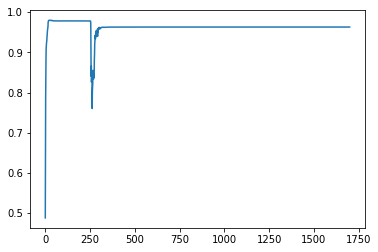

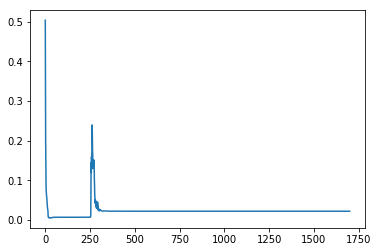

 85%|████████▌ | 1701/2000 [08:50<01:33,  3.21it/s]

S(a)
[ 0.01150978] [ 0.98849022]
S(f)
[ 0.01421863] [ 0.98578137]
¬S(b)
[ 0.010768] [ 0.989232]
F(b, c)
[ 0.99786305] [ 0.00213697]
¬F(e, g)
[ 0.01063591] [ 0.98936409]
C(a)
[ 0.01159096] [ 0.98840904]
C(e)
[ 0.02176416] [ 0.97823584]
¬C(b)
[ 0.01642019] [ 0.98357981]
¬C(c)
[ 0.01452744] [ 0.98547256]
¬C(d)
[ 0.01190078] [ 0.98809922]
¬C(f)
[ 0.0156579] [ 0.9843421]
¬C(g)
[ 0.01111257] [ 0.98888743]
¬C(h)
[ 0.01360691] [ 0.98639309]
S(n)
[ 0.01318693] [ 0.98681307]
¬S(j)
[ 0.01099998] [ 0.98900002]
¬S(k)
[ 0.01534331] [ 0.98465669]
¬S(m)
[ 0.01246053] [ 0.98753947]
17


 90%|█████████ | 1800/2000 [09:14<01:01,  3.24it/s]

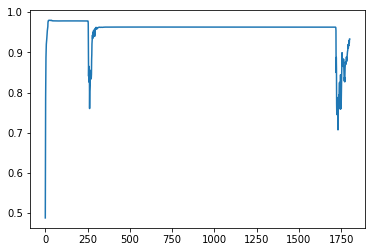

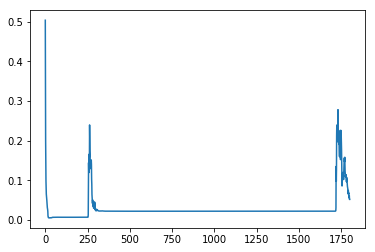

 90%|█████████ | 1801/2000 [09:15<01:01,  3.24it/s]

S(e)
[ 0.01339561] [ 0.98660439]
S(f)
[ 0.01722759] [ 0.98277241]
S(g)
[ 0.01176828] [ 0.98823172]
¬S(b)
[ 0.01627785] [ 0.98372215]
F(a, f)
[ 0.02968299] [ 0.97031701]
F(b, c)
[ 0.99999231] [  7.68027985e-06]
F(g, h)
[ 0.99998099] [  1.89958482e-05]
¬F(a, d)
[ 0.03982037] [ 0.96017963]
C(a)
[ 0.03142458] [ 0.96857542]
C(e)
[ 0.03229958] [ 0.96770042]
¬C(b)
[ 0.01136827] [ 0.98863173]
¬C(f)
[ 0.0203988] [ 0.9796012]
¬C(g)
[ 0.02128673] [ 0.97871327]
¬S(m)
[ 0.01487571] [ 0.98512429]
F(k, l)
[ 0.01600242] [ 0.98399758]
F(m, n)
[ 0.99847978] [ 0.00152024]
16


 95%|█████████▌| 1900/2000 [09:39<00:30,  3.28it/s]

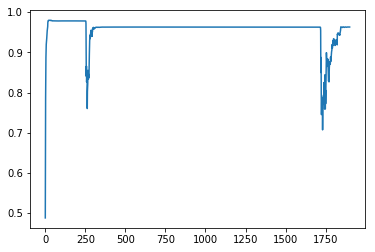

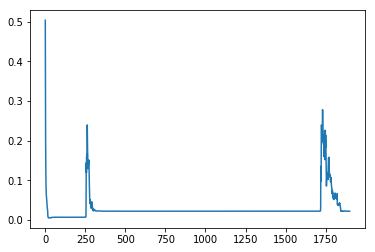

 95%|█████████▌| 1901/2000 [09:39<00:30,  3.28it/s]

S(a)
[ 0.01159197] [ 0.98840803]
S(f)
[ 0.01442409] [ 0.98557591]
F(b, c)
[ 0.9985323] [ 0.00146773]
¬F(e, g)
[ 0.01135904] [ 0.98864096]
C(a)
[ 0.0117566] [ 0.9882434]
C(e)
[ 0.020643] [ 0.979357]
¬C(b)
[ 0.01577497] [ 0.98422503]
¬C(c)
[ 0.01454347] [ 0.98545653]
¬C(d)
[ 0.01305032] [ 0.98694968]
¬C(f)
[ 0.01599652] [ 0.98400348]
¬C(g)
[ 0.01250839] [ 0.98749161]
¬C(h)
[ 0.01306862] [ 0.98693138]
S(n)
[ 0.0137881] [ 0.9862119]
¬S(j)
[ 0.01108664] [ 0.98891336]
¬S(k)
[ 0.01449567] [ 0.98550433]
¬S(l)
[ 0.01044524] [ 0.98955476]
¬S(m)
[ 0.01307547] [ 0.98692453]
17


100%|██████████| 2000/2000 [10:03<00:00,  3.31it/s]


In [21]:
ltn1=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]])
kb_train=kb1.union(kb2)
optimizor=torch.optim.Adam(ltn1.parameters(),lr=0.1,weight_decay=0.1)
mone=torch.FloatTensor([-1])
one=torch.FloatTensor([1])
average_prob=[]
averate_loss=[]
for i in tqdm(range(2000)):
    optimizor.zero_grad()
    total_probability=0.0
    total_loss=0.0
    for clause in kb_train.clauses:
        loss,prob=ltn1.forward(clause=clause)
        loss.backward(one)
        total_probability+=prob.data.numpy()[0]
        total_loss+=loss.data.numpy()[0]
    optimizor.step()
    average_prob.append(total_probability/len(kb_train.clauses))
    averate_loss.append(total_loss/len(kb_train.clauses))
    
    if i%100==0:
        plt.plot(average_prob)
        plt.show()
        plt.plot(averate_loss)
        plt.show()
        show_results(ltn1, kb_train)

In [25]:
c=Clause(1,1,[Predicate('F',['c','b'],False)])
print(ltn1.forward(c))
print(c.show())

(Variable containing:
1.00000e-02 *
  7.9611
[torch.FloatTensor of size 1]
, Variable containing:
 0.9204
[torch.FloatTensor of size 1]
)
F(c, b)



  0%|          | 0/2000 [00:00<?, ?it/s]

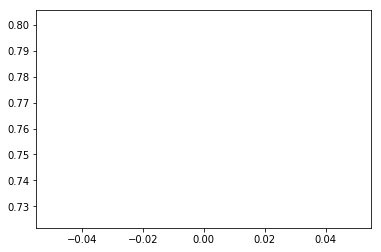

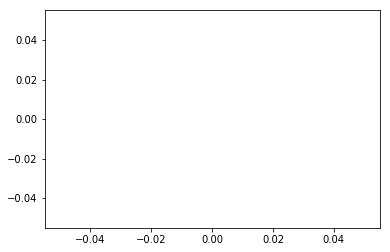

¬S(i) ∨ C(i)
0.999967 3.28403e-05
¬S(i) ∨ ¬F(i, j) ∨ S(j)
0.999586 0.000414431
¬S(i) ∨ ¬F(i, l) ∨ S(l)
0.997065 0.00293487
¬S(k) ∨ ¬F(k, j) ∨ S(j)
0.562536 0.437464
¬S(k) ∨ ¬F(k, l) ∨ S(l)
0.730473 0.269527
¬S(k) ∨ ¬F(k, m) ∨ S(m)
0.200082 0.799918
¬S(k) ∨ ¬F(k, n) ∨ S(n)
0.730473 0.269527
¬F(i, i) ∨ F(i, i)
0.28875 0.71125
¬F(i, j) ∨ F(j, i)
0.982799 0.0172014
¬F(i, l) ∨ F(l, i)
0.681322 0.318678
¬F(j, k) ∨ F(k, j)
0.437464 0.562536
¬F(j, l) ∨ F(l, j)
0.907557 0.0924428
¬F(j, n) ∨ F(n, j)
0.0436706 0.956329
¬F(k, i) ∨ F(i, k)
0.997872 0.00212765
¬F(k, j) ∨ F(j, k)
0.0297787 0.970221
¬F(k, m) ∨ F(m, k)
0.200082 0.799918
¬F(k, n) ∨ F(n, k)
0.999914 8.58307e-05
¬F(m, i) ∨ F(i, m)
0.982785 0.0172148
¬F(m, k) ∨ F(k, m)
0.516389 0.483611
¬F(m, l) ∨ F(l, m)
0.973237 0.0267631
¬F(m, n) ∨ F(n, m)
0.954235 0.0457647
¬F(n, i) ∨ F(i, n)
0.999784 0.000216067
¬F(n, j) ∨ F(j, n)
0.178497 0.821503
¬F(n, n) ∨ F(n, n)
0.0473002 0.9527
¬F(i, i)
0.28875 0.71125
¬F(l, l)
1.0 3.57628e-07
¬F(m, m)
1.0 0.0
¬


  0%|          | 1/2000 [00:06<3:45:29,  6.77s/it]

0.000144551
F(c, d)
0.998947 0.00105302
F(e, f)
0.253655 0.746345
F(g, h)
1.0 1.47258e-08
¬F(a, c)
0.999978 2.15769e-05
¬F(a, d)
0.999858 0.000142097
¬F(b, d)
0.783331 0.216669
¬F(b, e)
0.999887 0.00011313
¬F(b, f)
0.986685 0.013315
¬F(c, e)
0.940482 0.0595183
¬F(c, g)
0.305189 0.694811
¬F(d, e)
0.516962 0.483038
¬F(d, f)
0.127914 0.872086
¬F(d, h)
0.864821 0.135179
¬F(e, g)
0.965782 0.0342185
¬F(f, g)
0.844696 0.155304
C(a)
0.999963 3.74586e-05
¬C(b)
0.990892 0.00910848
¬C(c)
0.0228243 0.977176
¬C(f)
0.999994 5.72205e-06
¬C(g)
1.0 2.38419e-07
¬C(h)
0.999702 0.000298202
117



Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/sunxiaofei/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/sunxiaofei/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/sunxiaofei/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  5%|▌         | 100/2000 [07:35<2:24:19,  4.56s/it]

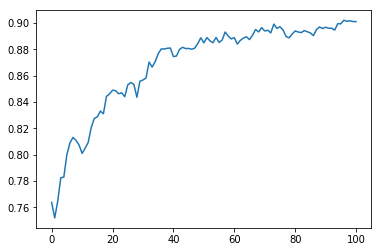

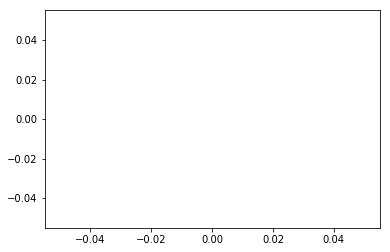

¬S(i) ∨ ¬F(i, j) ∨ S(j)
0.0269589 0.973041
¬S(i) ∨ ¬F(i, m) ∨ S(m)
0.650642 0.349358
¬S(k) ∨ ¬F(k, j) ∨ S(j)
0.0440266 0.955973
F(i, i) ∨ F(i, j) ∨ F(i, k) ∨ F(i, l) ∨ F(i, m) ∨ F(i, n)
0.349358 0.650642
F(k, i) ∨ F(k, j) ∨ F(k, k) ∨ F(k, l) ∨ F(k, m) ∨ F(k, n)
0.955973 0.0440266
¬F(i, j) ∨ F(j, i)
0.0269589 0.973041
¬F(k, j) ∨ F(j, k)
0.0440266 0.955973
¬F(l, j) ∨ F(j, l)
0.997081 0.00291854
¬F(m, i) ∨ F(i, m)
0.349358 0.650642
¬F(n, m) ∨ F(m, n)
0.982923 0.0170768
¬S(g) ∨ C(g)
0.224109 0.775891
¬S(a) ∨ ¬F(a, a) ∨ S(a)
0.0102258 0.989774
¬S(a) ∨ ¬F(a, d) ∨ S(d)
0.0102258 0.989774
¬S(a) ∨ ¬F(a, e) ∨ S(e)
0.0102258 0.989774
¬S(a) ∨ ¬F(a, f) ∨ S(f)
0.0102258 0.989774
¬S(g) ∨ ¬F(g, a) ∨ S(a)
0.0824531 0.917547
¬S(g) ∨ ¬F(g, d) ∨ S(d)
0.888589 0.111411
¬S(g) ∨ ¬F(g, e) ∨ S(e)
0.136586 0.863414
F(g, a) ∨ F(g, b) ∨ F(g, c) ∨ F(g, d) ∨ F(g, e) ∨ F(g, f) ∨ F(g, g) ∨ F(g, h)
0.111411 0.888589
¬F(a, g) ∨ F(g, a)
0.917547 0.0824532
¬F(b, a) ∨ F(a, b)
0.483566 0.516434
¬F(b, c) ∨ F(c, b)
0.61824 0

  5%|▌         | 101/2000 [07:43<2:25:19,  4.59s/it]

¬F(a, d)
0.983661 0.0163388
¬F(b, e)
0.998005 0.00199467
¬F(c, e)
0.999984 1.5974e-05
¬F(d, e)
0.961473 0.038527
¬F(e, h)
0.994865 0.00513452
¬C(d)
0.0113711 0.988629
¬C(f)
1.0 2.38419e-07
¬C(g)
0.775891 0.224109
55


 10%|█         | 200/2000 [13:35<2:02:15,  4.08s/it]

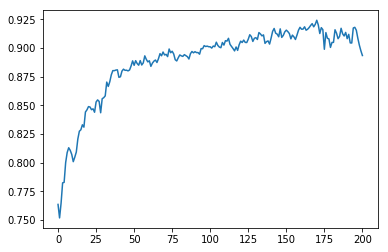

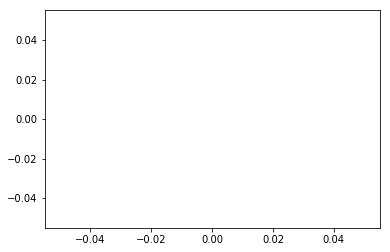

F(k, i) ∨ F(k, j) ∨ F(k, k) ∨ F(k, l) ∨ F(k, m) ∨ F(k, n)
0.999963 3.71318e-05
F(l, i) ∨ F(l, j) ∨ F(l, k) ∨ F(l, l) ∨ F(l, m) ∨ F(l, n)
0.996622 0.0033778
¬F(i, j) ∨ F(j, i)
0.76611 0.23389
¬F(m, m) ∨ F(m, m)
0.0101128 0.989887
¬F(n, l) ∨ F(l, n)
0.0122289 0.987771
¬F(m, m)
0.0101128 0.989887
¬F(n, n)
0.999978 2.20537e-05
¬S(d) ∨ C(d)
0.999866 0.00013411
¬S(g) ∨ C(g)
0.677575 0.322425
¬S(d) ∨ ¬F(d, a) ∨ S(a)
0.996775 0.00322455
¬S(d) ∨ ¬F(d, b) ∨ S(b)
0.856931 0.143069
¬S(d) ∨ ¬F(d, e) ∨ S(e)
0.998467 0.00153322
¬S(d) ∨ ¬F(d, h) ∨ S(h)
0.0969861 0.903014
¬S(g) ∨ ¬F(g, a) ∨ S(a)
0.677575 0.322425
F(c, a) ∨ F(c, b) ∨ F(c, c) ∨ F(c, d) ∨ F(c, e) ∨ F(c, f) ∨ F(c, g) ∨ F(c, h)
0.0877462 0.912254
¬F(a, b) ∨ F(b, a)
0.0538503 0.94615
¬F(a, c) ∨ F(c, a)
0.0765228 0.923477
¬F(a, h) ∨ F(h, a)
0.0626419 0.937358
¬F(b, c) ∨ F(c, b)
0.513888 0.486112
¬F(b, d) ∨ F(d, b)
0.143069 0.856931
¬F(b, e) ∨ F(e, b)
0.0427703 0.95723
¬F(b, g) ∨ F(g, b)
0.0328944 0.967106
¬F(d, b) ∨ F(b, d)
0.0704491 0.929551

 10%|█         | 201/2000 [13:39<2:02:17,  4.08s/it]

¬F(h, e) ∨ F(e, h)
0.99423 0.00577033
¬F(a, a)
1.0 0.0
¬F(b, b)
0.99166 0.0083403
¬F(e, e)
1.0 0.0
¬F(f, f)
0.0875087 0.912491
S(i)
0.999472 0.000528416
S(n)
0.999491 0.000508819
F(i, j)
0.23389 0.76611
F(k, l)
0.999985 1.45364e-05
¬F(j, n)
0.999881 0.00011909
S(a)
0.999931 6.86524e-05
S(e)
0.998467 0.00153322
S(f)
0.999778 0.000222318
S(g)
0.322425 0.677575
¬S(d)
0.999866 0.00013411
F(a, f)
0.0246351 0.975365
F(b, c)
0.486112 0.513888
F(c, d)
1.0 1.20241e-12
F(g, h)
0.999992 8.28352e-06
¬F(a, c)
0.0765228 0.923477
¬F(a, d)
0.999985 1.49012e-05
¬F(a, h)
0.0626419 0.937358
¬F(b, d)
0.929551 0.0704491
¬F(b, e)
0.0427703 0.95723
¬F(b, g)
0.0328944 0.967106
¬F(c, e)
0.912254 0.0877462
¬F(d, e)
0.999963 3.68357e-05
¬F(d, h)
0.0969861 0.903014
¬F(e, g)
0.0277758 0.972224
C(a)
0.080063 0.919937
C(e)
0.128677 0.871323
¬C(c)
0.0132217 0.986778
¬C(f)
0.0137491 0.986251
64


 15%|█▌        | 300/2000 [19:51<1:52:30,  3.97s/it]

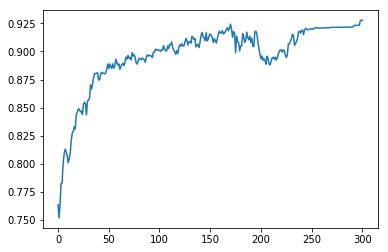

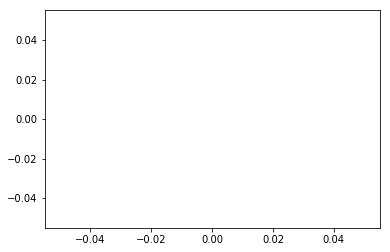

F(k, i) ∨ F(k, j) ∨ F(k, k) ∨ F(k, l) ∨ F(k, m) ∨ F(k, n)
0.999824 0.000176011
F(l, i) ∨ F(l, j) ∨ F(l, k) ∨ F(l, l) ∨ F(l, m) ∨ F(l, n)
0.999962 3.77395e-05
¬F(i, j) ∨ F(j, i)
0.0373932 0.962607
¬F(n, n)
1.0 0.0
¬S(d) ∨ ¬F(d, a) ∨ S(a)
0.0159132 0.984087
F(h, a) ∨ F(h, b) ∨ F(h, c) ∨ F(h, d) ∨ F(h, e) ∨ F(h, f) ∨ F(h, g) ∨ F(h, h)
0.88919 0.11081
¬F(a, e) ∨ F(e, a)
0.0621815 0.937818
¬F(c, a) ∨ F(a, c)
0.230709 0.769291
¬F(c, d) ∨ F(d, c)
0.0237843 0.976216
¬F(d, a) ∨ F(a, d)
0.0115722 0.988428
¬F(f, e) ∨ F(e, f)
0.0112273 0.988773
¬F(h, b) ∨ F(b, h)
0.11081 0.88919
¬F(a, a)
1.0 0.0
¬F(e, e)
0.998908 0.00109231
¬F(f, f)
0.99997 3.016e-05
S(i)
0.999757 0.000243258
S(n)
0.999928 7.17393e-05
F(i, j)
0.962607 0.0373931
F(k, l)
0.999979 2.08029e-05
¬F(j, n)
0.999965 3.46899e-05
S(a)
1.0 1.18117e-08
S(e)
0.998592 0.00140748
S(f)
0.999987 1.27246e-05
S(g)
0.997954 0.00204574
¬S(d)
0.0159132 0.984087
F(b, c)
0.992819 0.00718144
F(c, d)
0.976216 0.0237843
F(e, f)
0.0112273 0.988773
F(g, h)
1.0

 15%|█▌        | 301/2000 [19:56<1:52:33,  3.97s/it]

¬C(d)
0.999995 5.126e-06
32


 20%|██        | 400/2000 [26:59<1:47:59,  4.05s/it]

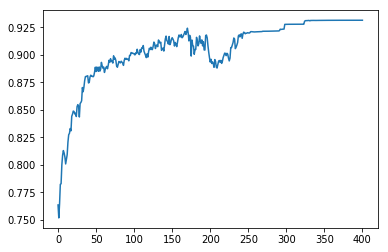

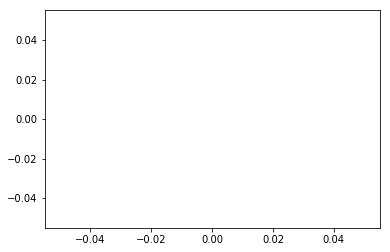

F(k, i) ∨ F(k, j) ∨ F(k, k) ∨ F(k, l) ∨ F(k, m) ∨ F(k, n)
0.844794 0.155206
F(l, i) ∨ F(l, j) ∨ F(l, k) ∨ F(l, l) ∨ F(l, m) ∨ F(l, n)
0.999952 4.84772e-05
¬F(i, j) ∨ F(j, i)
0.0171546 0.982845
¬F(k, j) ∨ F(j, k)
0.155206 0.844794
¬F(n, n)
0.99999 1.03712e-05
F(h, a) ∨ F(h, b) ∨ F(h, c) ∨ F(h, d) ∨ F(h, e) ∨ F(h, f) ∨ F(h, g) ∨ F(h, h)
0.999458 0.000542287
¬F(c, a) ∨ F(a, c)
0.527877 0.472123
¬F(d, a) ∨ F(a, d)
0.163409 0.836591
¬F(f, e) ∨ F(e, f)
0.01131 0.98869


 20%|██        | 401/2000 [27:05<1:48:00,  4.05s/it]

¬F(a, a)
1.0 0.0
¬F(e, e)
0.998544 0.00145578
¬F(f, f)
0.999998 1.90735e-06
S(i)
0.999871 0.000129106
S(n)
0.99975 0.000250423
F(i, j)
0.982845 0.0171546
F(k, l)
0.999996 3.60727e-06
¬F(j, n)
0.999857 0.000143051
S(a)
1.0 3.96539e-10
S(e)
0.999869 0.000130727
S(f)
0.999986 1.41327e-05
S(g)
0.999679 0.000320772
F(b, c)
0.99996 3.96077e-05
F(c, d)
0.999969 3.13077e-05
F(e, f)
0.01131 0.98869
F(g, h)
1.0 3.71791e-09
¬F(a, c)
0.472123 0.527877
¬F(a, d)
0.836591 0.163409
27


 25%|██▌       | 500/2000 [34:10<1:42:30,  4.10s/it]

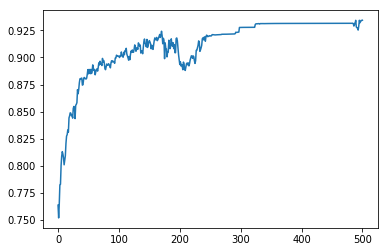

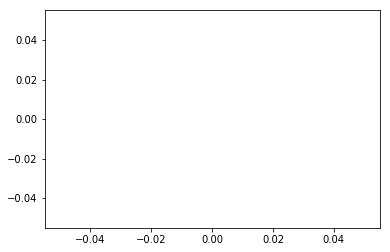

¬S(n) ∨ ¬F(n, m) ∨ S(m)
0.187914 0.812086
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
0.279725 0.720275
¬F(j, i) ∨ F(i, j)
0.720275 0.279725
¬F(k, i) ∨ F(i, k)
0.199172 0.800828
¬F(l, i) ∨ F(i, l)
0.959407 0.0405928
¬F(d, a) ∨ F(a, d)
0.954995 0.0450049
¬F(h, a) ∨ F(a, h)
0.991314 0.00868596
¬F(a, a)
1.0 0.0
¬F(e, e)
0.99997 2.99215e-05
¬F(f, f)
0.999929 7.12872e-05
S(i)
1.0 1.71518e-10
S(n)
0.812086 0.187914
F(i, j)
0.998019 0.00198058
F(k, l)
0.997534 0.00246594
¬F(i, k)
0.800828 0.199172
¬F(i, l)
0.0405928 0.959407
S(a)
1.0 6.95196e-11
S(e)
0.999558 0.000441752
S(f)
0.999999 7.89589e-07


 25%|██▌       | 501/2000 [34:14<1:42:27,  4.10s/it]

S(g)
0.999503 0.000496774
F(b, c)
0.999947 5.31859e-05
F(c, d)
0.999999 1.259e-06
F(g, h)
1.0 9.75674e-10
¬F(a, c)
0.99999 1.01328e-05
¬F(a, d)
0.0450049 0.954995
25


 30%|███       | 600/2000 [39:36<1:32:26,  3.96s/it]

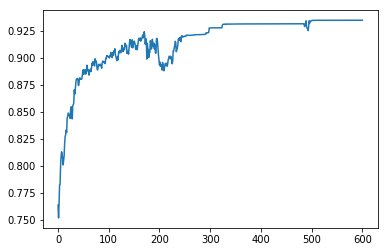

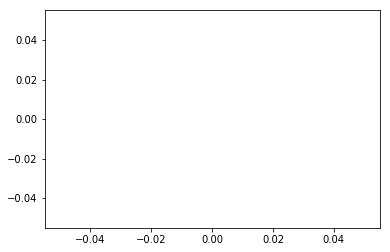

¬S(n) ∨ ¬F(n, m) ∨ S(m)
0.0100932 0.989907
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
0.986045 0.0139554
¬F(j, i) ∨ F(i, j)
0.0139554 0.986045
¬F(k, i) ∨ F(i, k)
0.99987 0.000130436
¬F(l, i) ∨ F(i, l)
0.999735 0.000265413
¬F(d, a) ∨ F(a, d)
0.122507 0.877493
¬F(h, a) ∨ F(a, h)
0.497952 0.502048
¬F(a, a)
1.0 0.0
¬F(e, e)
0.999933 6.69956e-05
¬F(f, f)
0.995219 0.00478071
S(i)
0.999998 1.614e-06
S(n)
0.989907 0.0100932
F(i, j)
0.999996 3.52591e-06
F(k, l)
0.999041 0.000958967


 30%|███       | 601/2000 [39:42<1:32:24,  3.96s/it]

S(a)
1.0 5.93507e-09
S(e)
0.999953 4.72138e-05
S(f)
1.0 4.73346e-08
S(g)
0.999658 0.000342338
F(b, c)
0.999999 8.89595e-07
F(c, d)
0.999987 1.27252e-05
F(g, h)
1.0 3.26956e-10
¬F(a, c)
0.999891 0.000108957
¬F(a, d)
0.877493 0.122507
¬F(a, h)
0.502048 0.497952
24


 35%|███▌      | 700/2000 [45:53<1:25:13,  3.93s/it]

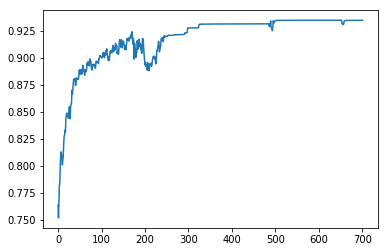

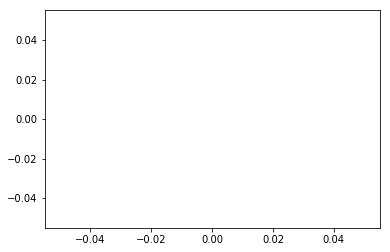

¬S(n) ∨ ¬F(n, m) ∨ S(m)
0.883961 0.116039
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
0.999977 2.3434e-05
F(k, i) ∨ F(k, j) ∨ F(k, k) ∨ F(k, l) ∨ F(k, m) ∨ F(k, n)
0.999978 2.16552e-05
F(l, i) ∨ F(l, j) ∨ F(l, k) ∨ F(l, l) ∨ F(l, m) ∨ F(l, n)
0.999973 2.70928e-05
¬F(e, e) ∨ F(e, e)
0.21224 0.78776
¬F(a, a)
1.0 0.0
¬F(e, e)
0.78776 0.21224
S(i)
0.994974 0.0050259
S(n)
0.116039 0.883961
F(i, j)
1.0 2.97627e-08
F(k, l)
0.999999 1.44469e-06
S(a)
0.999999 1.24209e-06
S(e)
0.999907 9.29209e-05
S(f)
0.999797 0.000202669
S(g)
0.999631 0.000368649
F(b, c)
1.0 5.40045e-08
F(c, d)
1.0 1.60005e-07
F(e, f)
0.999918 8.16721e-05
F(g, h)
1.0 1.15326e-13
¬F(a, c)
1.0 1.19209e-07
¬F(a, d)
0.999992 7.51019e-06
¬F(a, h)
0.995942 0.00405842


 35%|███▌      | 701/2000 [45:58<1:25:11,  3.93s/it]

22


 40%|████      | 800/2000 [52:24<1:18:37,  3.93s/it]

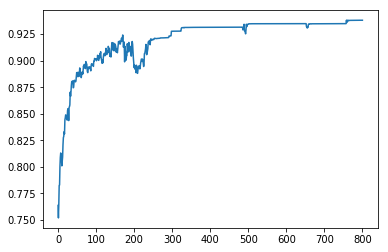

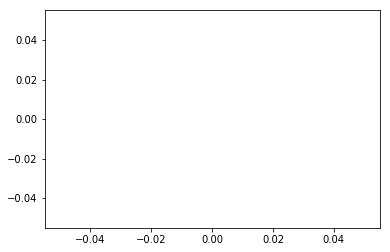

¬S(i) ∨ ¬F(i, m) ∨ S(m)
0.999661 0.000338912
¬S(n) ∨ ¬F(n, m) ∨ S(m)
0.99099 0.00900972
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
0.999969 3.07332e-05
F(k, i) ∨ F(k, j) ∨ F(k, k) ∨ F(k, l) ∨ F(k, m) ∨ F(k, n)
0.999977 2.34098e-05
F(l, i) ∨ F(l, j) ∨ F(l, k) ∨ F(l, l) ∨ F(l, m) ∨ F(l, n)
0.999973 2.66201e-05
¬S(e) ∨ ¬F(e, a) ∨ S(a)
0.719671 0.280329
¬F(c, a) ∨ F(a, c)
0.193273 0.806727
¬F(h, a) ∨ F(a, h)
0.18807 0.81193
¬F(a, a)
1.0 0.0
F(i, j)
0.999965 3.54238e-05
F(k, l)
1.0 7.18977e-08
S(a)
1.0 9.17321e-09
S(e)
0.280329 0.719671
S(f)
0.999888 0.000112476
S(g)
0.999756 0.000243742


 40%|████      | 801/2000 [52:32<1:18:38,  3.94s/it]

F(b, c)
0.999787 0.000213308
F(c, d)
1.0 5.04012e-07
F(e, f)
0.999963 3.68506e-05
F(g, h)
1.0 1.16142e-09
¬F(a, c)
0.806727 0.193273
¬F(a, d)
0.999735 0.000265181
¬F(a, h)
0.81193 0.18807
22


 45%|████▌     | 900/2000 [1:00:14<1:13:37,  4.02s/it]

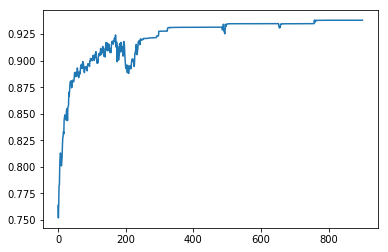

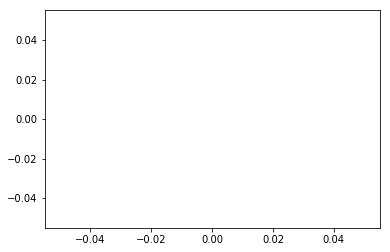

¬S(i) ∨ ¬F(i, m) ∨ S(m)
0.999637 0.000362515
¬S(n) ∨ ¬F(n, m) ∨ S(m)
0.998617 0.00138295
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
0.999972 2.84108e-05
F(k, i) ∨ F(k, j) ∨ F(k, k) ∨ F(k, l) ∨ F(k, m) ∨ F(k, n)
0.999974 2.55733e-05
F(l, i) ∨ F(l, j) ∨ F(l, k) ∨ F(l, l) ∨ F(l, m) ∨ F(l, n)
0.999974 2.59656e-05
¬S(e) ∨ ¬F(e, a) ∨ S(a)
0.273797 0.726203
¬F(c, a) ∨ F(a, c)
0.0114677 0.988532
¬F(d, a) ∨ F(a, d)
0.261262 0.738738
¬F(a, a)
1.0 0.0
F(i, j)
0.999983 1.73128e-05
F(k, l)
1.0 1.32807e-08
S(a)

 45%|████▌     | 901/2000 [1:00:19<1:13:34,  4.02s/it]


0.999982 1.84727e-05
S(e)
0.726203 0.273797
S(f)
0.999966 3.39538e-05
S(g)
0.999758 0.000242322
F(b, c)
0.99999 9.85373e-06
F(c, d)
0.999996 4.16477e-06
F(e, f)
0.999982 1.7762e-05
F(g, h)
1.0 4.19915e-07
¬F(a, c)
0.988532 0.0114677
¬F(a, d)
0.738738 0.261262
¬F(a, h)
0.996643 0.0033567
22


 50%|█████     | 1000/2000 [1:06:42<1:06:42,  4.00s/it]

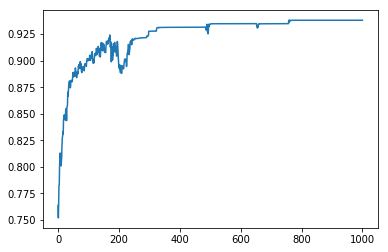

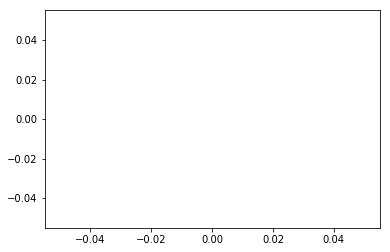

¬S(i) ∨ ¬F(i, m) ∨ S(m)
0.999517 0.000482798
¬S(n) ∨ ¬F(n, m) ∨ S(m)
0.999306 0.000694394
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
0.999973 2.67297e-05
F(k, i) ∨ F(k, j) ∨ F(k, k) ∨ F(k, l) ∨ F(k, m) ∨ F(k, n)
0.999974 2.59141e-05
F(l, i) ∨ F(l, j) ∨ F(l, k) ∨ F(l, l) ∨ F(l, m) ∨ F(l, n)
0.999975 2.5225e-05
¬S(e) ∨ ¬F(e, a) ∨ S(a)
0.953375 0.046625
¬F(c, a) ∨ F(a, c)
0.0429934 0.957007
¬F(d, a) ∨ F(a, d)
0.741019 0.258981
¬F(h, a) ∨ F(a, h)
0.0149907 0.985009
¬F(a, a)
1.0 0.0
F(i, j)
0.999984 1.57515e-05
F(k, l)


 50%|█████     | 1001/2000 [1:06:47<1:06:39,  4.00s/it]

1.0 5.96904e-09
S(a)
0.999952 4.75124e-05
S(e)
0.046625 0.953375
S(f)
0.999892 0.000108339
S(g)
0.999757 0.00024271
F(b, c)
0.999991 9.26918e-06
F(c, d)
0.999998 2.3659e-06
F(e, f)
0.999994 6.06891e-06
F(g, h)
0.999998 1.59045e-06
¬F(a, c)
0.957007 0.0429934
¬F(a, d)
0.258981 0.741019
¬F(a, h)
0.985009 0.0149907
23


 52%|█████▏    | 1048/2000 [1:10:02<1:03:37,  4.01s/it]


KeyboardInterrupt: 

In [27]:
kb_train=kb1.union(kb2).union(gkb1).union(gkb2)
ltn2=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]])
optimizor=torch.optim.Adam(ltn2.parameters(),lr=0.1,weight_decay=0.1)
mone=torch.FloatTensor([-1])
one=torch.FloatTensor([1])
average_prob=[]
average_loss=[]
for i in tqdm(range(2000)):
    optimizor.zero_grad()
    total_probability=0.0
    total_loss=0.0
    for clause in kb_train.clauses:
        loss,prob=ltn2.forward(clause=clause)
        loss.backward(one)
        total_probability+=prob.data.numpy()[0]
        total_loss+=loss.data.numpy()[0]
    optimizor.step()
    average_prob.append(total_probability/len(kb_train.clauses))
    average_loss.append(total_loss/len(kb_train.clauses))
    if i%100==0:
        plt.plot(average_prob)
        plt.show()
        plt.plot(averate_loss)
        plt.show()
        show_results(ltn2,kb_train)

In [21]:
show_results(ltn2,kb1)

S(a)
0.999971 2.89519e-05
S(e)
0.147613 0.852387
S(f)
0.999794 0.000206059
S(g)
0.999794 0.000206492
F(b, c)
0.999995 4.89541e-06
F(c, d)
0.999995 5.00549e-06
F(e, f)
0.999994 5.82879e-06
F(g, h)
0.999995 4.9862e-06
¬F(a, c)
0.999897 0.000103474
¬F(a, d)
0.999893 0.000106812
¬F(a, h)
0.999878 0.000121951
11


In [37]:
import pandas as pd
import numpy

In [49]:
data={
}
pd.DataFrame(index=list('abcd'),columns=['a','b','c'])

,a,b,c
a,NaN,NaN,NaN
b,NaN,NaN,NaN
c,NaN,NaN,NaN
d,NaN,NaN,NaN


In [119]:
def get_DF_S(model,constants):
    constants=list(constants)
    df=pd.DataFrame(index=constants,columns=['S'])
    for a in constants:
        clause=Clause(1,1,[Predicate(name='S',variables=[a],negation=False)])
        result=model.forward(clause)
        df['S'][a]='%0.2f'%result[1].data.numpy()[0]
    return df

In [120]:
def get_DF_C(model,constants):
    constants=list(constants)
    df=pd.DataFrame(index=constants,columns=['C'])
    for a in constants:
        clause=Clause(1,1,[Predicate(name='C',variables=[a],negation=False)])
        result=model.forward(clause)
        df['C'][a]='%0.2f'%result[1].data.numpy()[0]
    return df

In [131]:
def get_DF_F(model,constants):
    constants=list(constants)
    df=pd.DataFrame(index=constants, columns=constants)
    for a in constants:
        for b in constants:
#             if a>=b:
#                 df[b][a]='-'
#                 continue
            clause=Clause(1,1,[Predicate(name='F',variables=[a,b],negation=False)])
            result=model.forward(clause)
            df[b][a]='%0.2f'%result[1].data.numpy()[0]
    return df

In [132]:
def get_DF(model,constants):
    df1=get_DF_S(model,constants)
    df2=get_DF_C(model,constants)
    df3=get_DF_F(model,constants)
    df=pd.concat([df1,df2,df3],axis=1)
    return df

In [136]:
get_DF(ltn1,'abcdefgh')

,S,C,a,b,c,d,e,f,g,h
a,1.00,1.00,0.08,1.00,0.00,0.00,1.00,1.00,1.00,0.00
b,0.00,0.00,1.00,0.02,1.00,0.00,0.00,0.00,0.00,0.00
c,0.00,0.00,1.00,0.92,0.93,1.00,0.00,0.00,0.00,0.00
d,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00
e,1.00,1.00,1.00,1.00,1.00,0.34,0.96,1.00,0.00,0.00
f,1.00,0.00,0.04,1.00,1.00,0.98,0.54,1.00,0.00,0.00
g,1.00,0.00,1.00,0.26,0.88,0.09,0.00,1.00,0.00,1.00
h,0.00,0.00,0.98,0.99,0.00,0.00,0.37,0.00,0.00,0.00


In [134]:
get_DF(ltn1,'ijklmn')

,S,C,i,j,k,l,m,n
i,1.00,1.00,0.91,1.00,0.00,0.00,1.00,0.00
j,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
k,0.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00
l,0.00,0.88,1.00,0.53,0.00,0.00,0.00,0.00
m,0.00,0.03,1.00,0.08,0.31,0.97,0.07,1.00
n,1.00,1.00,1.00,1.00,0.15,1.00,0.09,0.99
